## Linear regression

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot

### Data preprocessing

In [6]:
df = pd.read_csv('podatki_PM.csv')

print('Null values: \n',df.isnull().sum())
df = df.drop(columns=['Datum'])

df.fillna(df.mean(), inplace=True)

print('Null values: \n',df.isnull().sum())
print('\n')
num_instances, num_features = df.shape
df['PM10'].astype(float) 
print(f"Number of instances: {num_instances}")
print(f"Number of features: {num_features}")


Null values: 
 Datum                         0
Glob_sevanje_mean             0
Hitrost_vetra_mean            0
Sunki_vetra_max               0
Padavine_sum                  0
Vlaga_mean                    0
Temperatura_Krvavec_mean      0
Temperatura_lokacija_mean     0
PM10                          0
PM_vceraj                    33
sinD                          0
cosD                          0
dtype: int64
Null values: 
 Glob_sevanje_mean            0
Hitrost_vetra_mean           0
Sunki_vetra_max              0
Padavine_sum                 0
Vlaga_mean                   0
Temperatura_Krvavec_mean     0
Temperatura_lokacija_mean    0
PM10                         0
PM_vceraj                    0
sinD                         0
cosD                         0
dtype: int64


Number of instances: 1213
Number of features: 11


### Data splitting and target variable selection

In [7]:
y = df['PM10']  
X = df.drop(columns=['PM10'])                
print(f"Range of y (PM10): [{y.min()}-{y.max()}]")

# 70/30 train-test split without random shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_s = scaler_X.fit_transform(X_train)
X_test_s = scaler_X.transform(X_test)

y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten() 
y_test_s = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")


Range of y (PM10): [1.8-114.9]
Training features shape: (849, 10)
Testing features shape: (364, 10)
Training target shape: (849,)
Testing target shape: (364,)


### Multiple Linear Regression

In [8]:
class MultipleLinearRegression:
    def __init__(self, polynomial_degree=1, log_transform=False):
        """
        Initialize the MultipleLinearRegression model.

        Parameters:
        polynomial_degree : int, optional
            The degree of polynomial features to generate (default is 1, which means no polynomial features).
        log_transform : bool, optional
            If True, the target variable will be log-transformed (default is False).
        """
        self.beta = None
        self.polynomial_degree = polynomial_degree
        self.log_transform = log_transform
        
        self.y_predict = None
        self.residual = None
        self.residual_norm = None  
        self.nparams = None
        self.nresids = None  
        self.leverage = None 
        self.cooks_distance = None 

    def fit(self, X, y):
        """
        Fit the model to the given data.

        Parameters:
        X : numpy array or pandas DataFrame
            The input features.
        y : numpy array or pandas Series
            The target variable.

        This method computes the coefficients of the regression model,
        as well as the fitted values, residuals, and diagnostic measures.
        """
        if self.log_transform:
            y = np.log(y)

        if self.polynomial_degree > 1:
            X = self._generate_polynomial_features(X)

        X = np.c_[np.ones(X.shape[0]), X]
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ y 

        self.y_predict = X @ self.beta
        self.residual = y - self.y_predict
        self.nparams = X.shape[1]
        self.nresids = X.shape[0]
        self.residual_norm = self.residual / np.std(self.residual)

        self.leverage = self._calculate_leverage(X)
        self.cooks_distance = self._calculate_cooks_distance()

    def predict(self, X):
        """
        Predict the target variable using the learned coefficients.

        Parameters:
        X : numpy array or pandas DataFrame
            The input features for prediction.

        Returns:
        numpy array
            The predicted values.
        """
        if self.polynomial_degree > 1:
            X = self._generate_polynomial_features(X)

        X = np.c_[np.ones(X.shape[0]), X]  
        predictions = X @ self.beta

        # Reversing logarithmic transformation if it was applied to the target
        if self.log_transform:
            predictions = np.exp(predictions)

        return predictions
        
    def _generate_polynomial_features(self, X):
        """
        Generate polynomial features of the specified degree.

        Parameters:
        X : numpy array or pandas DataFrame
            The input features.

        Returns:
        numpy array
            The input features with added polynomial features.
        """
        X_poly = X.copy()
        for degree in range(2, self.polynomial_degree + 1):
            X_poly = np.c_[X_poly, X ** degree]
        return X_poly

    def _calculate_leverage(self, X):
        """
        Calculate leverage for each observation.

        Leverage measures how much an observation influences the fitted values.

        Parameters:
        X : numpy array
            The input features with a bias term.

        Returns:
        numpy array
            An array of leverage values for each observation.
        """
        # Leverage calculation (H = X(X'X)^(-1)X')
        hat_matrix = X @ np.linalg.inv(X.T @ X) @ X.T
        #  The diagonal elements of the hat matrix represent the leverage scores for each observation. These scores indicate how much influence each observation has on the fitted values. Observations with high leverage have a greater impact on the regression model.
        return np.diag(hat_matrix)

    def _calculate_cooks_distance(self):
        """
        Calculate Cook's distance for each observation.

        Cook's distance helps identify influential data points that significantly affect the regression results.

        Returns:
        numpy array
            An array of Cook's distance values for each observation.
        """
        residuals_sq = self.residual**2
        return (residuals_sq / (self.nparams * np.var(self.residual))) * (self.leverage / (1 - self.leverage)**2)

    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves.

        Parameters:
        factor : float
            A factor used to determine the Cook's distance curve.

        Returns:
        tuple
            Two numpy arrays: x values and corresponding y values for the Cook's distance curve.
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates of the top residuals.

        Parameters:
        quantiles : numpy array
            The theoretical quantiles from the Q-Q plot.
        top_residual_indices : list of int
            Indices of the top residuals.

        Yields:
        tuple
            An index and corresponding x, y coordinates for the Q-Q plot.
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative is None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y

    def qq_plot(self, ax=None):
        """
        Standardized Residual vs Theoretical Quantile plot.

        Based on Fox and Weisberg's techniques for checking normality.

        Parameters:
        ax : matplotlib Axes, optional
            The axes on which to plot (default is None, which creates a new figure).

        Returns:
        matplotlib Axes
            The axes containing the Q-Q plot.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # Annotations for top 3 residuals
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot.

        Used to check homoscedasticity of the residuals.
        Based on Fox and Weisberg's methods.

        Parameters:
        ax : matplotlib Axes, optional
            The axes on which to plot (default is None, which creates a new figure).

        Returns:
        matplotlib Axes
            The axes containing the scale-location plot.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5)
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # Annotations for top 3 squared residuals
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$')
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot.

        Based on Fox and Weisberg's methods for identifying influential observations.

        Parameters:
        ax : matplotlib Axes, optional
            The axes on which to plot (default is None, which creates a new figure).
        high_leverage_threshold : bool, optional
            If True, a line indicating high leverage will be added (default is False).
        cooks_threshold : str, optional
            Method to calculate Cook's distance threshold ('baseR', 'convention', 'dof', default is 'baseR').

        Returns:
        matplotlib Axes
            The axes containing the leverage plot.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5)

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # Annotations for top leverage
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color='C3')

        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4 / self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4 / (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage) + 0.01)
        ax.set_ylim(min(self.residual_norm) - 0.1, max(self.residual_norm) + 0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def residual_plot(self, ax=None):
        """
        Create a Residual vs. Fitted Plot.
    
        Parameters:
        ax : matplotlib axes object, optional
            The axes on which to plot (if None, a new figure will be created).
        """
        if ax is None:
            fig, ax = plt.subplots()
    
        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)
    
        # Annotate top 3 largest residuals
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')
        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax
     
    def get_coefficients(self):
        """
        Get the learned coefficients of the model.

        Returns:
        numpy array
            The coefficients of the model.
        """
        return self.beta


In [9]:
model = MultipleLinearRegression()
model.fit(X_train, y_train)
y_pred_custom = model.predict(X_train)
print("Calculated coefficients (beta):", model.get_coefficients())

Calculated coefficients (beta): [ 4.64121501e+01  3.25713628e-02 -2.83160750e+00 -9.68148514e-01
 -2.27105425e-01 -2.37595054e-01  4.71115184e-01 -1.18019711e+00
  5.47713643e-01 -2.57394213e+00  1.53883545e+00]


### Test: Compare the manually written linear regression model with the scikit-learn model

In [10]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"Mean Squared Error: {mse:.3f}")
    print(f"R-squared: {r2:.3f}\n")

#### Fit the linear regression model from scikit-learn

In [11]:
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_train)

#### Custom model and scikit-learn model evaluation

In [12]:
evaluate_model(y_train, y_pred_custom, "Custom Multiple Linear Regression")
evaluate_model(y_train, y_pred_sklearn, "Scikit-Learn Linear Regression")

Custom Multiple Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667

Scikit-Learn Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667



#### Coefficient comparison between custom model and scikit-learn linear regression model

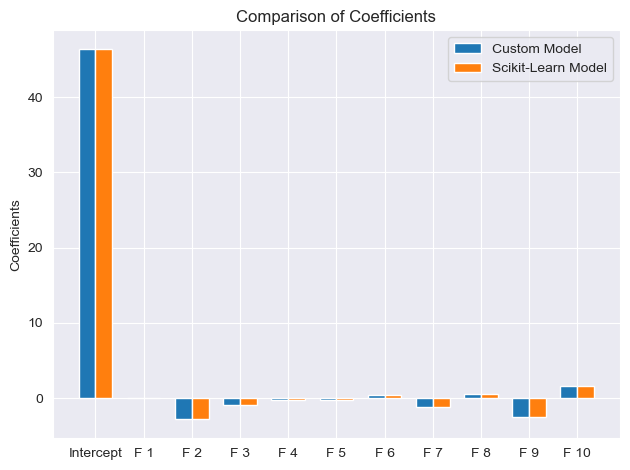

In [13]:
coefficients_custom = model.get_coefficients()
coefficients_sklearn = np.insert(sklearn_model.coef_, 0, sklearn_model.intercept_)

labels = [f'F {i+1}' for i in range(X.shape[1])]
labels = ['Intercept'] + labels

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, coefficients_custom, width, label='Custom Model')
rects2 = ax.bar(x + width/2, coefficients_sklearn, width, label='Scikit-Learn Model')

ax.set_ylabel('Coefficients')
ax.set_title('Comparison of Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.savefig('images/coefficients_comparison.png')
plt.show()


- The bar chart above compares the coefficients from a custom-built multiple linear regression model to those from the Scikit-Learn implementation of linear regression.
- **Interpretation of Coefficients:**
  - In both models, **the intercept** has the highest positive coefficient, indicating it is the most important predictor in the model. A one-unit increase in the intercept leads to a significant increase in the predicted target variable.
  - **Intercept:** Both models have a similar intercept, which represents the baseline value of the target variable when all feature values are zero.
  - **Other Features (F1 - F10):** The remaining features have relatively small coefficients in both models, suggesting they contribute less to the predictions. Specifically:
    - **Features F2 and F9** have a small, negative coefficient, meaning that as the feature increases, the target variable decreases slightly, though the effect is minimal.
    - Features F3 through F8 have very small coefficients, with values close to zero. This suggests that these features have little to no effect on the model’s predictions.

### Diagnosing the linear regression model with diagnostic plots

1. Residuals plot
2. QQ plot
3. Scale-location plot
4. Leverage plot

#### Residuals vs. Fitted Values Plot
Checking for non-linearity.
If there is a clear pattern (such as curves or a U-shape), it indicates non-linearity.

In [14]:
print('Custom Multiple Linear Regression Performance')
residuals = y_train - y_pred_custom

Custom Multiple Linear Regression Performance


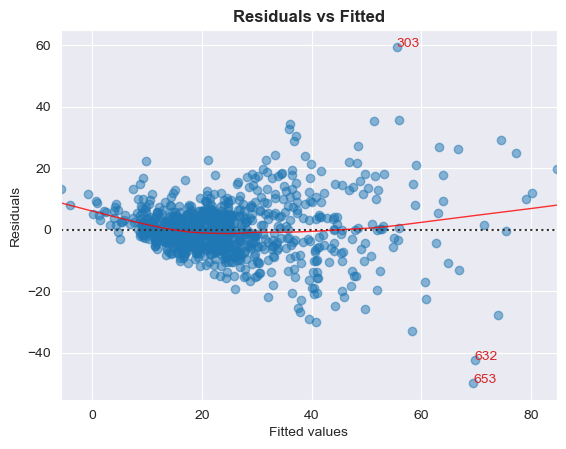

In [15]:
model.residual_plot()
plt.savefig('images/custom_model_plots/residual_plot1.png')
plt.show()

In this plot, we can observe a slight curved pattern in the residuals, indicating that the relationship between fitted values and residuals is not purely linear. Additionally, the spread of residuals seems to increase with the fitted values, suggesting non-constant variance. This pattern implies that the model might be heteroscedastic.

To confirm this, we can perform a Breusch-Pagan Test. A significant p-value (less than 0.05) in the Breusch-Pagan Test would indicate evidence of heteroscedasticity, confirming that the residual variance changes with the fitted values.

####  Breusch-Pagan Test for Heteroscedasticity

In [16]:
bp_test = het_breuschpagan(residuals, np.c_[np.ones(X_train.shape[0]), X_train])
# bp_test returns: (Lagrange Multiplier statistic, p-value, f-value, f p-value)
print(bp_test)
print(f'Breusch-Pagan test p-value: {bp_test[1]}')
if bp_test[1] < 0.05:
    print("The test indicates heteroscedasticity (p < 0.05).")
else:
    print("The test does not indicate heteroscedasticity (p >= 0.05).")

(183.95903511609995, 3.527334675416712e-34, 23.180176796207423, 1.0926041962590453e-38)
Breusch-Pagan test p-value: 3.527334675416712e-34
The test indicates heteroscedasticity (p < 0.05).


#### Standarized Residual vs Theoretical Quantile plot

With this plot we can see whether the dataset follows normal distribution. 

A Q-Q plot compares the quantiles of a dataset against the quantiles of a theoretical distribution, which in this case is the normal distribution. If the dataset is normally distributed, the points will fall approximately along a straight line.

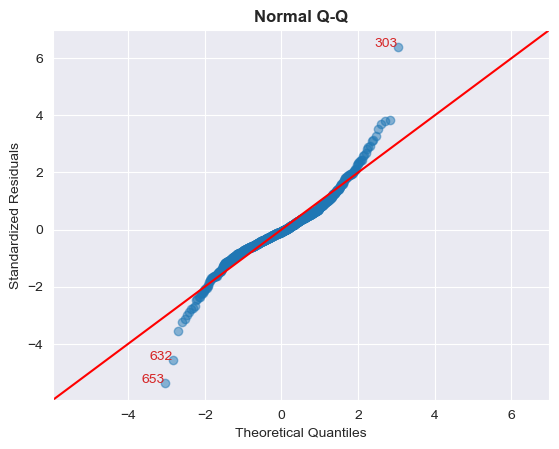

In [17]:
model.qq_plot()
plt.savefig('images/custom_model_plots/normal_qq_plot1.png')
plt.show()

Given that not all the data points fall on the diagonal line, we can say that the residuals are not normally distributed. 

### Sqrt(Standarized Residual) vs Fitted values plot
Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.

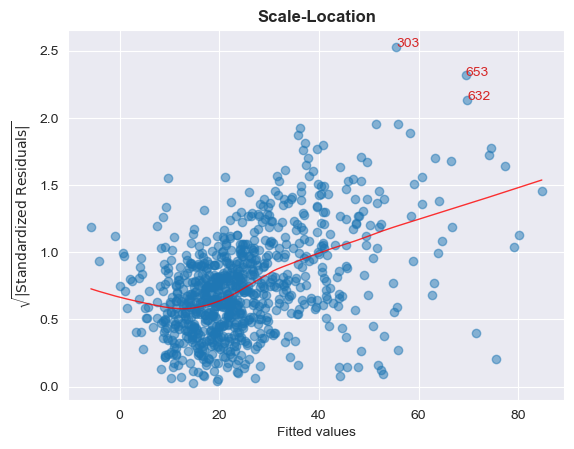

In [17]:
model.scale_location_plot()
plt.savefig('images/custom_model_plots/scale_location_plot1.png')
plt.show()

### Residual vs Leverage plot
Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        It is prefered to have none outside the curves.

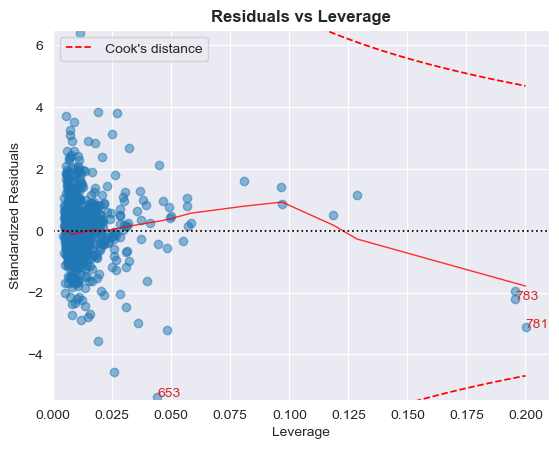

In [25]:
model.leverage_plot()
plt.savefig('images/custom_model_plots/residuals_vs_leverage_1.png')
plt.show()

In this plot, we observe that while some points are close to the Cook's distance boundary, none fall outside the Cook's distance curves. This suggests that there are no highly influential points in this model, this indicates that no single observation has a strong influence on the model’s fit.

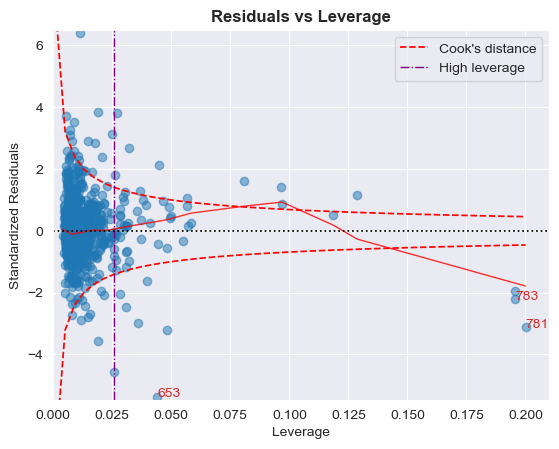

In [27]:
model.leverage_plot(high_leverage_threshold=True, cooks_threshold='dof')
plt.show()

### Attribute correlation

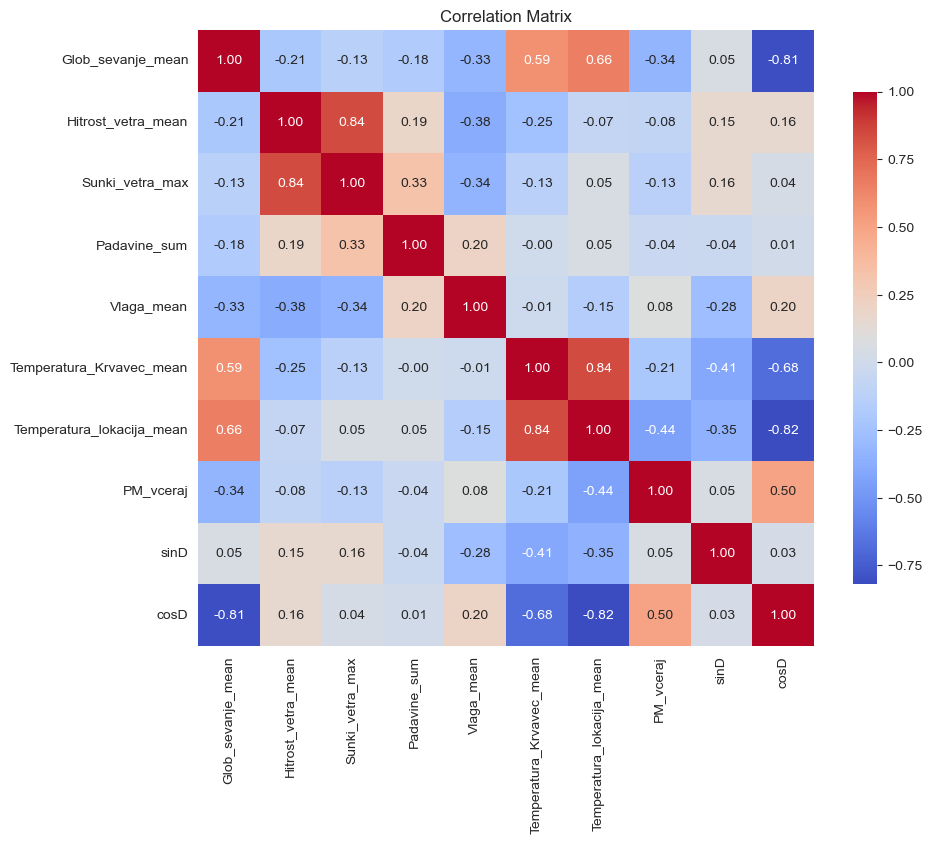

In [18]:
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')

plt.savefig('images/attribute_correlation.png', bbox_inches='tight') 

plt.show()

In the correlation matrix, we observe a high correlation between Temperatura_Krvavec_mean and Temperatura_lokacija_mean, as well as between Hitrost_vetra_mean and Sunki_vetra_max. High correlations between features can indicate redundancy, as these variables may convey similar information to the model.

To improve the model's performance and reduce multicollinearity, we can try removing one of each highly correlated pair. For instance, we can create a filtered dataset by dropping Hitrost_vetra_mean and Temperatura_Krvavec_mean and see how the model will perform. 

## Potential improvements

### Removing highly correlated attributes

In [19]:
evaluate_model(y_train, y_pred_custom, "Custom Multiple Linear Regression")

Custom Multiple Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667



In [20]:
X_filtered = X.drop(columns=['Hitrost_vetra_mean', 'Temperatura_Krvavec_mean'])
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y, test_size=0.3, shuffle=False)

model_filtered = MultipleLinearRegression()
model_filtered.fit(X_train_filtered, y_train_filtered)
y_pred_custom_filtered = model_filtered.predict(X_train_filtered)
print("Calculated coefficients (beta):", model_filtered.get_coefficients())

Calculated coefficients (beta): [38.82472606  0.04422979 -1.8078537  -0.19709613 -0.18457595 -0.77597385
  0.58212866 -2.79392021  1.28235849]


In [21]:
evaluate_model(y_train_filtered, y_pred_custom_filtered, "Custom Multiple Linear Regression Filtered")

Custom Multiple Linear Regression Filtered Performance:
Mean Absolute Error: 6.671
Mean Squared Error: 90.460
R-squared: 0.651



Performance comparison:
- The performance metrics for the custom multiple linear regression model show that removing the two attributes led to a slight decline in model performance. The Mean Absolute Error (MAE) increased from 6.536 to 6.671, and the Mean Squared Error (MSE) rose from 86.436 to 90.460. The R-squared value also decreased from 0.667 to 0.651.

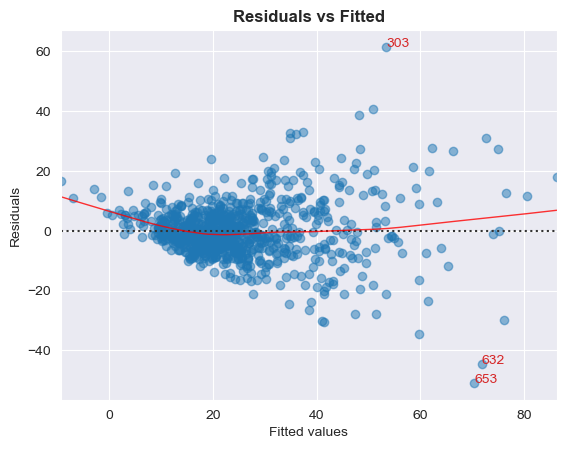

In [22]:
model_filtered.residual_plot()
plt.savefig('images/custom_model_plots/correlation_residuals_plot.png')
plt.show()

In this residual plot, we observe a more visible 'U' shape compared to the initial plot, indicating a notable decline in performance. This trend suggests that the model's predictions become increasingly biased at both extremes of the response variable, highlighting potential issues with model fit and indicating the presence of non-linearity in the data.

### Polynomial regression

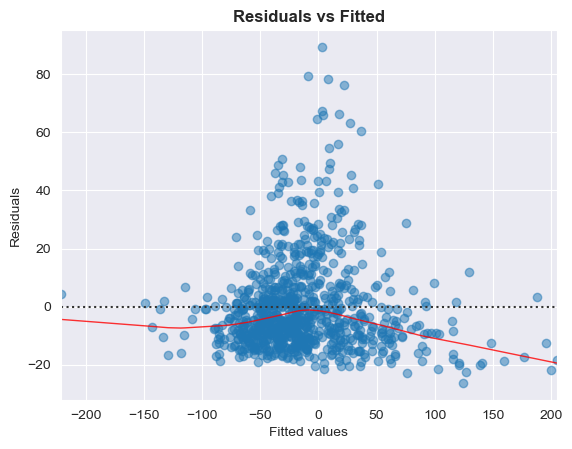

Custom Polynomial Linear Regression Performance:
Mean Absolute Error: 53.508
Mean Squared Error: 3852.776
R-squared: -13.853



In [19]:
polynomial_model = MultipleLinearRegression(polynomial_degree=2)
polynomial_model.fit(X_train, y_train)
y_pred_poly = polynomial_model.predict(X_train)

polynomial_model.residual_plot()
plt.savefig('images/custom_model_plots/polynomial_residuals_plot.png')
plt.show()

evaluate_model(y_train, y_pred_poly, "Custom Polynomial Linear Regression")

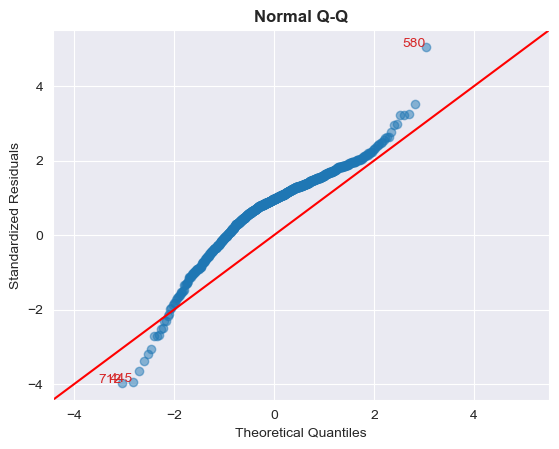

In [34]:
polynomial_model.qq_plot()
plt.savefig('images/custom_model_plots/polynomial_qq_plot.png')
plt.show()

Given the evaluation metrics, which indicate an R² value of -13 and a significantly high mean squared and absolute error, along with the observed plots that reveal non-linearity, heteroscedasticity, and a deviation from normal distribution in the residuals, we conclude that polynomial regression is not an appropriate model for this dataset. These findings suggest that polynomial regression is unlikely to improve the model's performance or provide reliable predictions.

### Logarithmic transformation on target variable

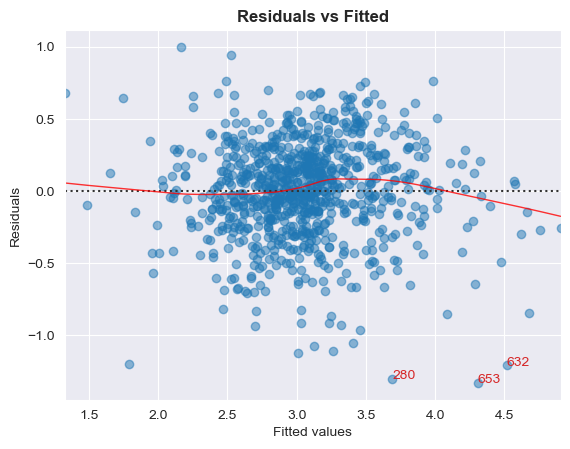

Custom Linear Regression with Log Transform Performance:
Mean Absolute Error: 6.477
Mean Squared Error: 98.113
R-squared: 0.622



In [23]:
log_model = MultipleLinearRegression(log_transform=True)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_train)

log_model.residual_plot()
plt.savefig('images/custom_model_plots/logarithmic_transformation_target_residual_plot.png')
plt.show()

evaluate_model(y_train, y_pred_log, "Custom Linear Regression with Log Transform")

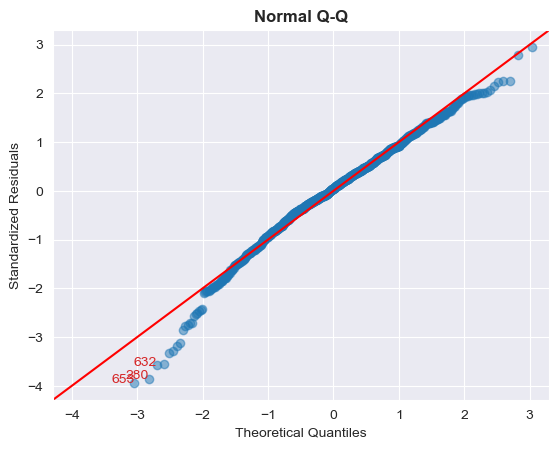

In [24]:
log_model.qq_plot()
plt.savefig('images/custom_model_plots/logarithmic_transformation_qq_plot.png')
plt.show()

Testing heteroscedasticity after logarithmic transformation on the target variable.

In [29]:
residuals2 = y_train - y_pred_log
bp_test = het_breuschpagan(residuals2, np.c_[np.ones(X_train.shape[0]), X_train])
# bp_test returns: (Lagrange Multiplier statistic, p-value, f-value, f p-value)
print(bp_test)
print(f'Breusch-Pagan test p-value: {bp_test[1]}')
if bp_test[1] < 0.05:
    print("The test indicates heteroscedasticity (p < 0.05).")
else:
    print("The test does not indicate heteroscedasticity (p >= 0.05).")

(184.2492303716826, 3.0700073916663153e-34, 23.226878719944967, 9.156923573116685e-39)
Breusch-Pagan test p-value: 3.0700073916663153e-34
The test indicates heteroscedasticity (p < 0.05).


In conclusion, applying a logarithmic transformation to the target variable yielded the best results among all approaches tested. The residuals plot shows nearly constant variation, however the model is still heteroscedastic. Moreover, the Q-Q plot demonstrates that the residuals approximate a normal distribution. The evaluation metrics are as follows: Mean Absolute Error (MAE): 6.477, Mean Squared Error (MSE): 98.113, and R-squared: 0.622. These metrics represent the best performance compared to all previous models, confirming the effectiveness of the logarithmic transformation in improving model accuracy.